# Credit Card Fraud

This dataset consists of credit card transactions in the western United States. It includes information about each transaction including customer details, the merchant and category of purchase, and whether or not the transaction was a fraud.

[Source](https://www.kaggle.com/kartik2112/fraud-detection?select=fraudTrain.csv) of dataset

In [1]:
import pandas as pd 
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

ccf = pd.read_csv('credit_card_fraud.csv') 
ccf.head(100)

ccf.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 339607 entries, 0 to 339606
Data columns (total 15 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   trans_date_trans_time  339607 non-null  object 
 1   merchant               339607 non-null  object 
 2   category               339607 non-null  object 
 3   amt                    339607 non-null  float64
 4   city                   339607 non-null  object 
 5   state                  339607 non-null  object 
 6   lat                    339607 non-null  float64
 7   long                   339607 non-null  float64
 8   city_pop               339607 non-null  int64  
 9   job                    339607 non-null  object 
 10  dob                    339607 non-null  object 
 11  trans_num              339607 non-null  object 
 12  merch_lat              339607 non-null  float64
 13  merch_long             339607 non-null  float64
 14  is_fraud               339607 non-nu

## Data Dictionary

| transdatetrans_time | Transaction DateTime                        |
|---------------------|---------------------------------------------|
| merchant            | Merchant Name                               |
| category            | Category of Merchant                        |
| amt                 | Amount of Transaction                       |
| city                | City of Credit Card Holder                  |
| state               | State of Credit Card Holder                 |
| lat                 | Latitude Location of Purchase               |
| long                | Longitude Location of Purchase              |
| city_pop            | Credit Card Holder's City Population        |
| job                 | Job of Credit Card Holder                   |
| dob                 | Date of Birth of Credit Card Holder         |
| trans_num           | Transaction Number                          |
| merch_lat           | Latitude Location of Merchant               |
| merch_long          | Longitude Location of Merchant              |
| is_fraud            | Whether Transaction is Fraud (1) or Not (0) |

There does not seem to be any evidence of missing data points. However, it is possible that the missing values are 

# Data Exploration

'Fraud comprises  0.5% of all transactions'

Text(0.5, 1.0, '')

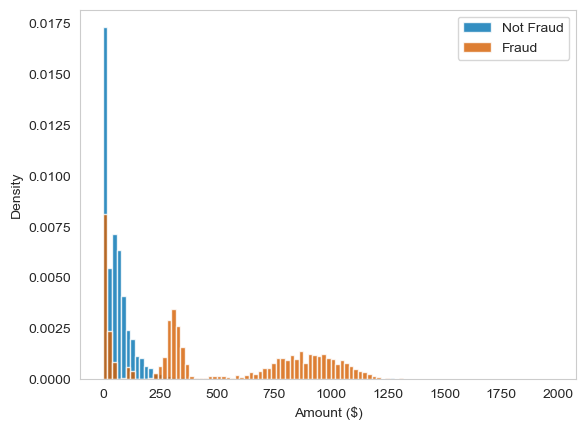

In [38]:
# The data set is massive and fraud should be relatively sparse. In order to get a better sense of what the data look like without imposing the computational load of interacting with 300K+ data points, we will sample the non-fraudulent data set such that so we have the same number of data points as the fraudulent transactions.

# Note that fraud makes up a tiny percentage of the overall data set
percent_fraud = np.round(ccf['is_fraud'].mean()*100,2)
display(f"Fraud comprises {percent_fraud: .1f}% of all transactions")
# Split the fraud and non-fraud datsets
ccf_fraud = ccf[ccf['is_fraud']==1]
ccf_true = ccf[ccf['is_fraud']==0]
ccf_true_smallsample = ccf_true.sample(len(ccf_fraud),random_state=21)
# Make the histogram
bins = np.arange(0,2000,20)
fig, ax = plt.subplots(1,1)

# Use a colorblind-friendly palette
colors = ["#0072B2", "#D55E00"]  # Blue, Orange (colorblind-friendly)

nonfraudcolor = colors[0]
fraudcolor = colors[1]
# Plotting non-fraudulent transactions
ccf_true_smallsample.hist('amt',
                          bins=bins,
                          ax=ax,
                          alpha=.8,
                          color=nonfraudcolor,
                          density=True,
                          grid=False
                          )
# Plotting fraudulent transactions
ccf_fraud.hist('amt',
               bins=bins,
               ax=ax,
               alpha=.8,
               color=fraudcolor,
               density=True,
               grid=False
               )

plt.legend(["Not Fraud","Fraud"])
plt.xlabel('Amount ($)')
plt.ylabel('Density')
plt.title('')



Although higher dollar amount transactions are more likely to be fraud, there is also fraud in the range of values that are mostly populated by non-fraudulent data. Presumably, other features (such as the location of the transaction compared to the location of the merchant) may provide more explanatory power. Let's next make column of the distance between the location of the merchant and the location of the purchase. We will generate the latitude and longitude and then simply calculate the hypotenuse to determine the distance.

<Axes: xlabel='Density', ylabel='amt'>

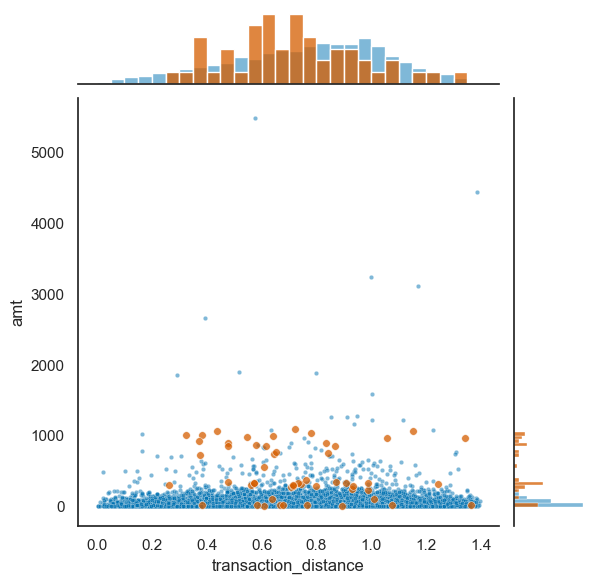

In [52]:
ccf['lat_diff'] = ccf['lat'] - ccf['merch_lat']
ccf['lon_diff'] = ccf['long'] - ccf['merch_long']
# Calculate hypotenuse
ccf['transaction_distance'] = np.sqrt(ccf['lat_diff']**2 + ccf['lon_diff']**2)
# Stratified sampling
num_samples = 10000
fraud_samples = int(num_samples * percent_fraud/100)
nonfraud_samples = num_samples - fraud_samples

fraud_sample = ccf[ccf['is_fraud']==1].sample(n=fraud_samples,random_state=21)
nonfraud_sample = ccf[ccf['is_fraud']==0].sample(n=nonfraud_samples,random_state=21)
# Concatenate fraud and non-fraud samples
ccf_sample = pd.concat([fraud_sample,nonfraud_sample])

sns.set_context('notebook')
sns.set_style('white')
g = sns.JointGrid(data=ccf_sample,x='transaction_distance',y='amt',hue='is_fraud',)
# g = g.plot_joint(sns.scatterplot, alpha=0.5)
# g = g.plot_marginals(sns.histplot,kde=True)
# Plot non-fraudulent transactions first with smaller points and lower alpha
sns.scatterplot(data=ccf_sample[ccf_sample['is_fraud'] == 0], x='transaction_distance', y='amt',
                ax=g.ax_joint, color=nonfraudcolor, alpha=0.5, s=10)

# Overlay with fraudulent transactions with larger points and higher alpha
sns.scatterplot(data=ccf_sample[ccf_sample['is_fraud'] == 1], x='transaction_distance', y='amt',
                ax=g.ax_joint, color=fraudcolor, alpha=0.75, s=30)


# Plot histograms with density on the margins for non-fraudulent transactions
sns.histplot(data=ccf_sample[ccf_sample['is_fraud'] == 0], 
             x='transaction_distance', 
             ax=g.ax_marg_x,
             stat='density', 
             color=nonfraudcolor, alpha=0.5,
             bins = np.arange(0,ccf_sample[ccf_sample['is_fraud'] == 0]['transaction_distance'].max(),0.05))
sns.histplot(data=ccf_sample[ccf_sample['is_fraud'] == 0], y='amt', 
             ax=g.ax_marg_y, 
             stat='density', 
             color=nonfraudcolor, alpha=0.5, 
             bins = np.arange(0,ccf_sample[ccf_sample['is_fraud'] == 0]['amt'].max(),50))

# Overlay with histograms with density on the margins for fraudulent transactions
sns.histplot(data=ccf_sample[ccf_sample['is_fraud'] == 1], x='transaction_distance',
             ax=g.ax_marg_x,
             stat='density', 
             color=fraudcolor, alpha=0.75,
             bins = np.arange(0,ccf_sample[ccf_sample['is_fraud'] == 1]['transaction_distance'].max(),0.05))
sns.histplot(data=ccf_sample[ccf_sample['is_fraud'] == 1], y='amt', 
             ax=g.ax_marg_y, 
             stat='density', 
             color=fraudcolor, alpha=0.75,
             bins = np.arange(0,ccf_sample[ccf_sample['is_fraud'] == 1]['amt'].max(),50))
